In [51]:
!pip install time
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 795.0 kB/s eta 0:00:0031m1.5 MB/s eta 0:00:01m


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2022-07-13 08:09:56.547867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 08:09:56.547890: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.9.1


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

In [410]:
data = pd.read_csv('data/handtyped_nn/train.csv')
label = data['label']

In [411]:
data /= 254
data['label'] = label

In [412]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


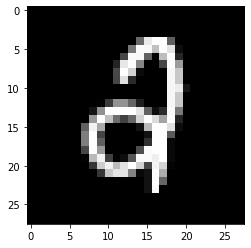

In [413]:
plt.imshow(data.values[10000][1:].reshape(28, 28), cmap='gray')

In [414]:
data.values[10000][1:].reshape(28, 28)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [463]:
def split_data_1to100(data):
    test = data.sort_values(by=['label'])[::100]
    train = pd.concat([data, test]).drop_duplicates(keep=False)
    sns.displot(test['label'], bins=10, kde=True);
    sns.displot(train['label'], bins=10, kde=True);
    return test, train

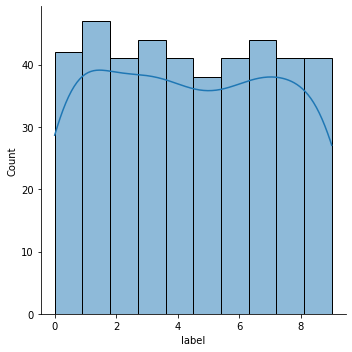

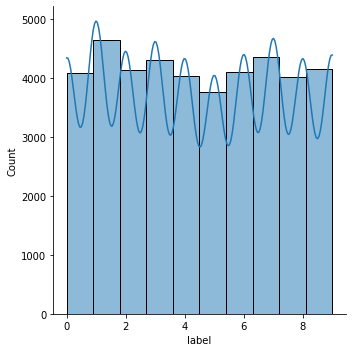

In [465]:
test, train = split_data_1to100(data)

In [595]:
class MyNN:
    def __init__(self):
        self.learn_rate = 0.01
        
        self._weights0 = np.random.rand(10, 16)-0.5
        self._weights1 = np.random.rand(16, 49)-0.5
        self._weights2 = np.random.rand(49, 784)-0.5

        self._input  = np.zeros([10])
        self._layer1 = np.zeros([16])
        self._layer2 = np.zeros([49])
        self._output = np.zeros([784])
        
        self._correction_0 = np.zeros([10, 16])
        self._correction_1 = np.zeros([16, 49])
        self._correction_2 = np.zeros([49, 784])
        
        self._activation0 = self.act_relu
        self._activation1 = self.act_relu
        self._activation2 = self.act_relu
        
        self._der_act_0 = self.der_act_relu
        self._der_act_1 = self.der_act_relu
        self._der_act_2 = self.der_act_relu
        
    def zero(self):
        self._input  = np.zeros([10])
        self._layer1 = np.zeros([16])
        self._layer2 = np.zeros([49])
        self._output = np.zeros([784])
    
    def act_sigmoid(self, layer):
        return np.array([1/(1+np.exp(-x)) for x in layer])

    def act_relu(self, layer):
        return np.array([x if x > 0 else 0 for x in layer])

    def act_softplus(self, layer):
        return np.array([np.ln(1+np.exp(x)) for x in layer])
    
    def der_act_sigmoid(self, l):
        _exp = np.exp(-l)
        return _exp / (1+_exp)**2
        
    def der_act_relu(self, l):
        if l > 0:
            return 1
        else:
            return 0
        
    def def_act_softplus(self, l):
        return 1 / (1+np.exp(-l))
    
    def predict(self, num):
        self.zero()
        self._input = np.array([100 if k == num[0] else 0 for k in range(10)])
        #print(num, self._input)
        
        self._layer1 = np.dot(self._input, self._weights0)
        self._layer1 = self._activation0(self._layer1)
        #print("   ", self._layer1)

        
        self._layer2 = np.dot(self._layer1, self._weights1)
        self._layer2 = self._activation1(self._layer2)
        
        self._output = np.dot(self._layer2, self._weights2)
        self._output = self._activation2(self._output)

        return self._output

    def learn(self, labels):
        
        main_delta   = self._output - labels
        delta_output = main_delta * [self._der_act_2(x) for x in self._output]
        delta_w_2    = np.dot(delta_output.reshape(len(delta_output), 1),
                              self._layer2.reshape(1, len(self._layer2)))
        
        delta_layer2 = np.dot(self._weights2, delta_output) * [self._der_act_1(x) for x in self._layer2]
        delta_w_1    = np.dot(delta_layer2.reshape(len(delta_layer2), 1),
                              self._layer1.reshape(1, len(self._layer1)))
        
        delta_layer1 = np.dot(self._weights1, delta_layer2) * [self._der_act_0(x) for x in self._layer1]
        delta_w_0    = np.dot(delta_layer1.reshape(len(delta_layer1), 1),
                              self._input.reshape(1, len(self._input)))
        
        self._correction_0 += np.transpose(delta_w_0)
        self._correction_1 += np.transpose(delta_w_1)
        self._correction_2 += np.transpose(delta_w_2)
    
    
    def gan_learn(self, err):
        
        main_delta   = np.array([err for i in range(784)])
        
        delta_output = main_delta * [self._der_act_2(x) for x in self._output]
        delta_w_2    = np.dot(delta_output.reshape(len(delta_output), 1),
                              self._layer2.reshape(1, len(self._layer2)))
        
        delta_layer2 = np.dot(self._weights2, delta_output) * [self._der_act_1(x) for x in self._layer2]
        delta_w_1    = np.dot(delta_layer2.reshape(len(delta_layer2), 1),
                              self._layer1.reshape(1, len(self._layer1)))
        
        delta_layer1 = np.dot(self._weights1, delta_layer2) * [self._der_act_0(x) for x in self._layer1]
        delta_w_0    = np.dot(delta_layer1.reshape(len(delta_layer1), 1),
                              self._input.reshape(1, len(self._input)))
        
        self._correction_0 += np.transpose(delta_w_0)
        self._correction_1 += np.transpose(delta_w_1)
        self._correction_2 += np.transpose(delta_w_2)
    
    def update(self, learn_rate):
        self._weights0 = self._weights0 - learn_rate * self._correction_0
        self._weights1 = self._weights1 - learn_rate * self._correction_1
        self._weights2 = self._weights2 - learn_rate * self._correction_2
        
        self._correction_0 = np.zeros([10, 16])
        self._correction_1 = np.zeros([16, 49])
        self._correction_2 = np.zeros([49, 784])
    

In [596]:
NN = MyNN()

NN._activation0 = NN.act_sigmoid
NN._activation1 = NN.act_sigmoid
NN._activation2 = NN.act_sigmoid

NN._der_act_0 = NN.der_act_sigmoid
NN._der_act_1 = NN.der_act_sigmoid
NN._der_act_2 = NN.der_act_sigmoid


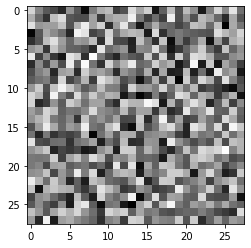

In [597]:
res = NN.predict([0])
plt.imshow(res.reshape(28, 28), cmap='gray')

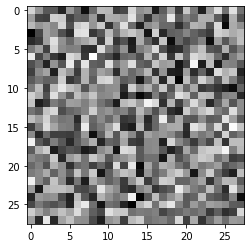

In [598]:
res = NN.predict([1])
plt.imshow(res.reshape(28, 28), cmap='gray')

In [599]:
def print_predictions(nn):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        res = nn.predict([i])
        plt.imshow(res.reshape(28, 28), cmap='gray')
        plt.xlabel(i)
    plt.show()


In [600]:
#data = data.sort_values(by=['label'])


E: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 111.43it/s]


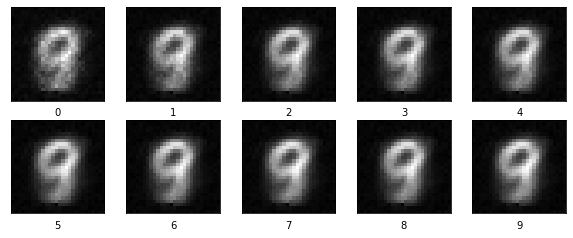

E: 1


  0%|                                                                                                               | 0/420 [00:00<?, ?it/s]/tmp/ipykernel_5437/2918186806.py:33: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1+np.exp(-x)) for x in layer])
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 105.22it/s]


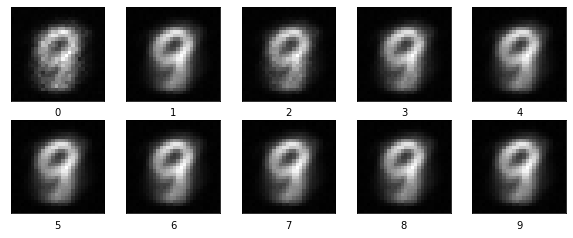

E: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 120.50it/s]


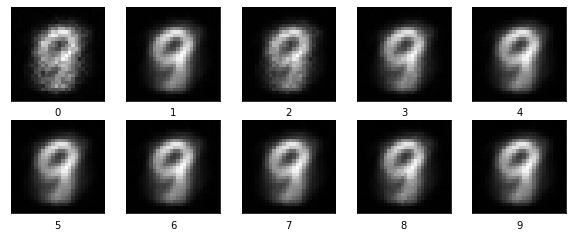

E: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 102.02it/s]


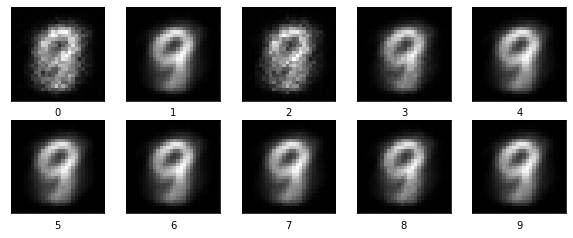

E: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 109.85it/s]


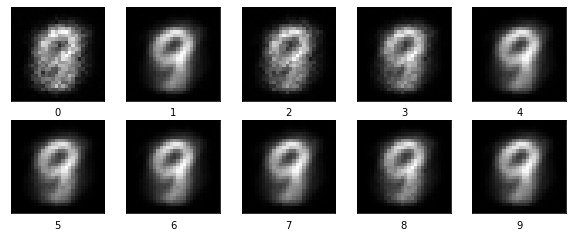

E: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 125.36it/s]


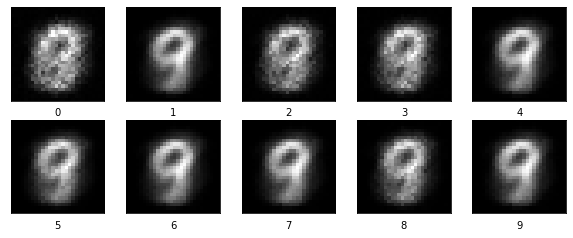

E: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 124.05it/s]


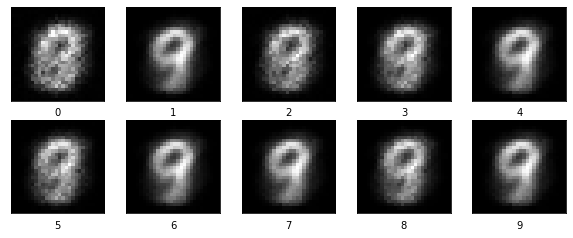

E: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 119.59it/s]


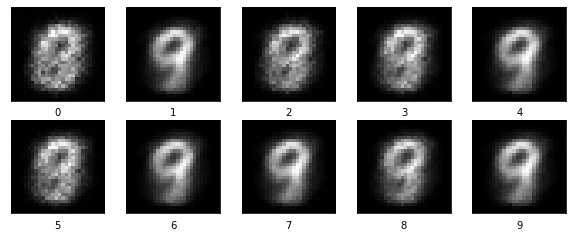

E: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 119.07it/s]


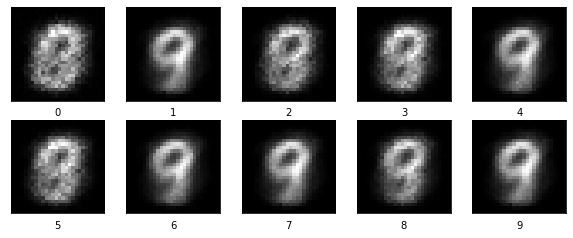

E: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 119.95it/s]


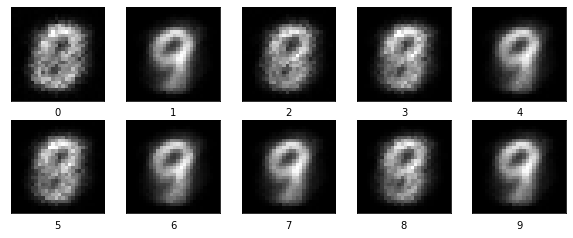

E: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 120.52it/s]


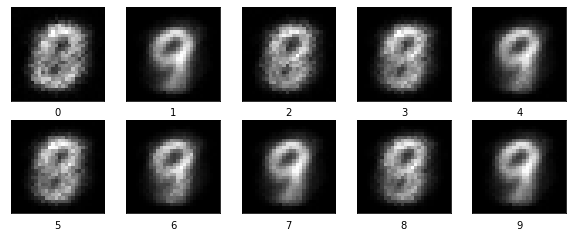

E: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 124.89it/s]


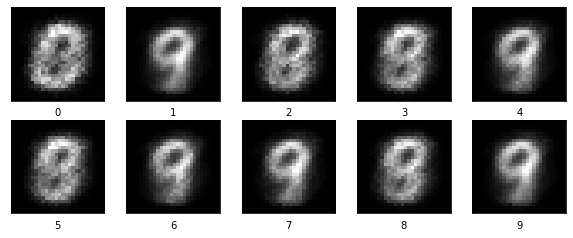

E: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:05<00:00, 81.45it/s]


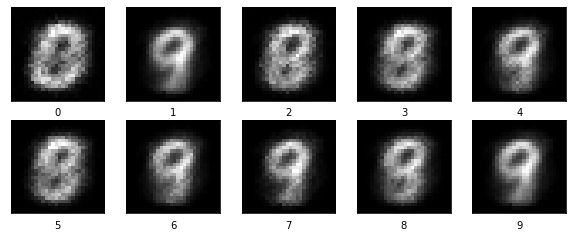

E: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 107.38it/s]


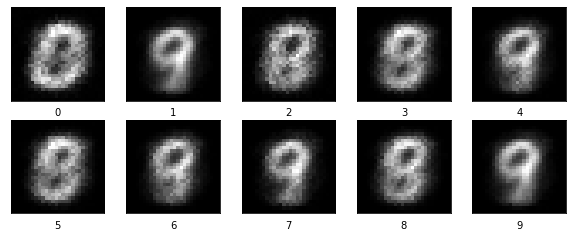

E: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 120.95it/s]


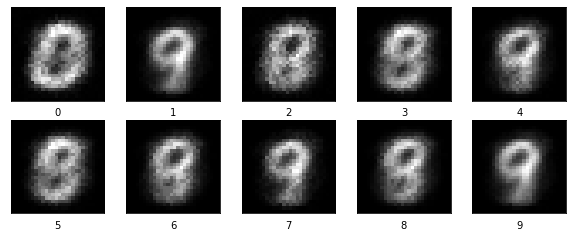

E: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 121.18it/s]


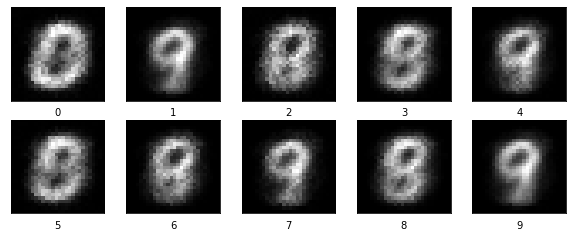

E: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 137.54it/s]


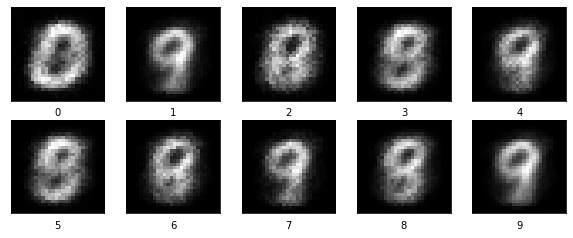

E: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 137.38it/s]


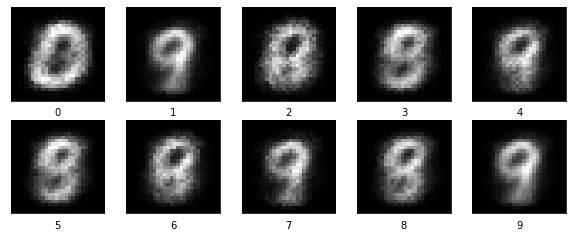

E: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 139.37it/s]


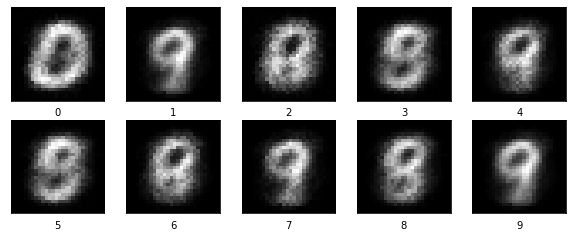

E: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:02<00:00, 141.78it/s]


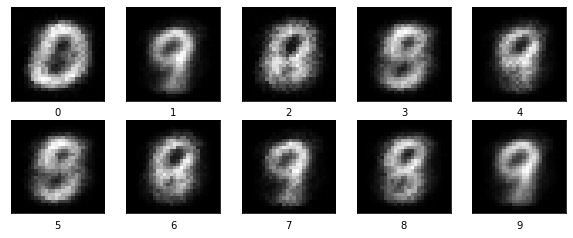

E: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 137.99it/s]


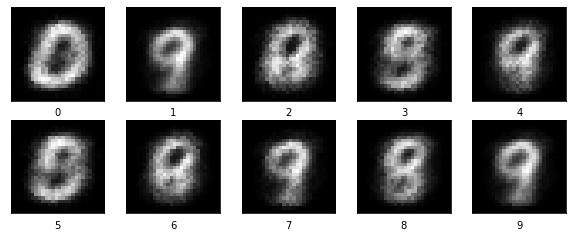

E: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 104.26it/s]


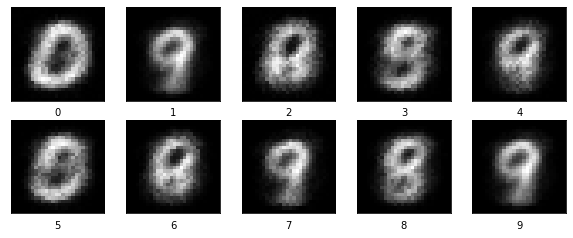

E: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 93.36it/s]


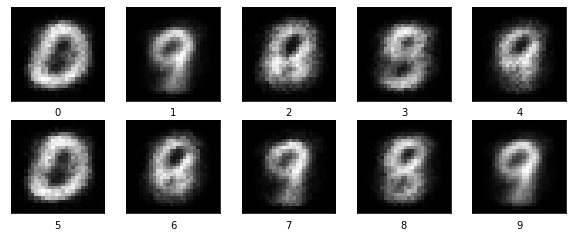

E: 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 118.71it/s]


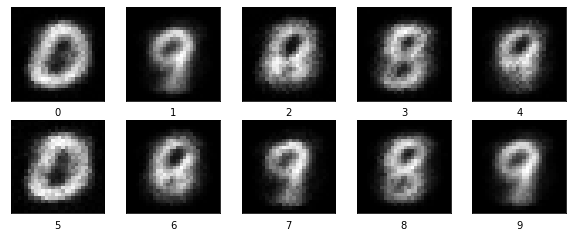

E: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 104.67it/s]


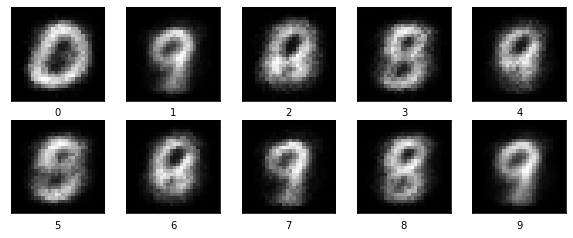

E: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 115.10it/s]


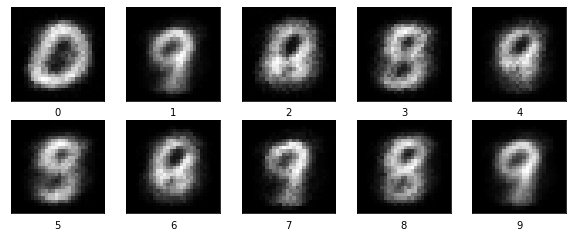

E: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 113.49it/s]


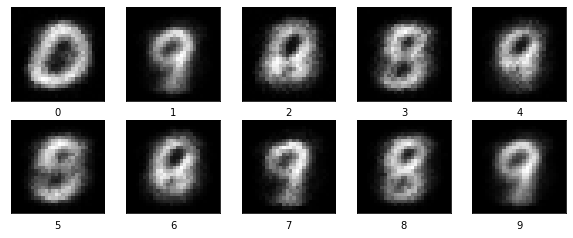

E: 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 108.43it/s]


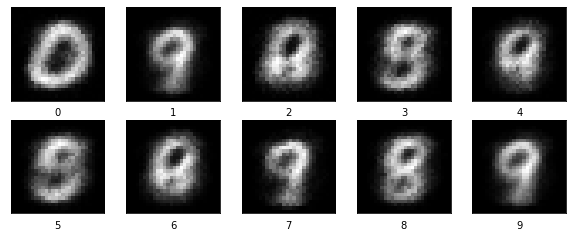

E: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 128.96it/s]


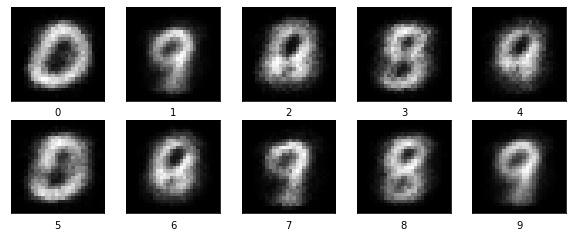

E: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 127.53it/s]


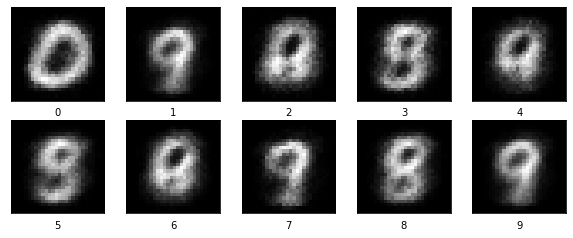

E: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 129.82it/s]


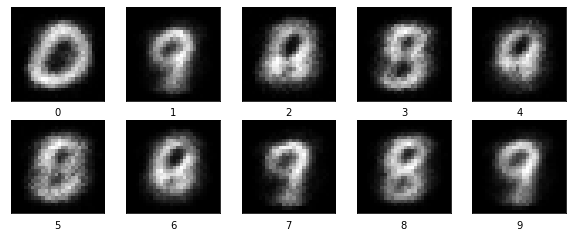

E: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 92.50it/s]


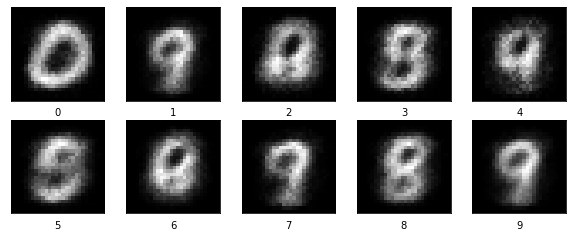

E: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 131.96it/s]


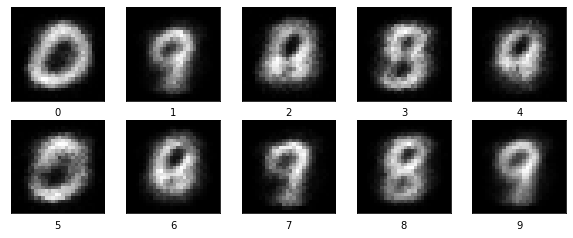

E: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 125.87it/s]


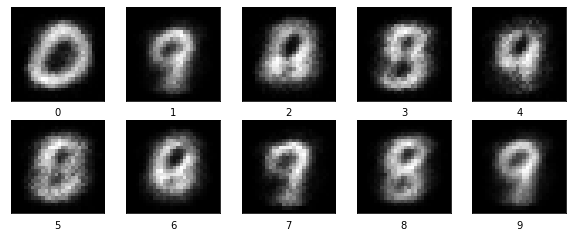

E: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 125.57it/s]


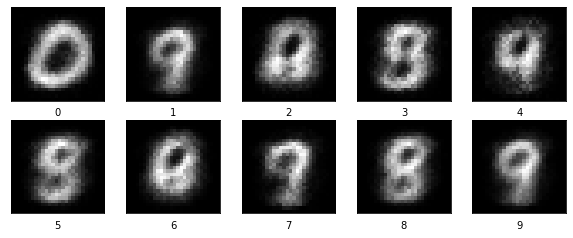

E: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 133.11it/s]


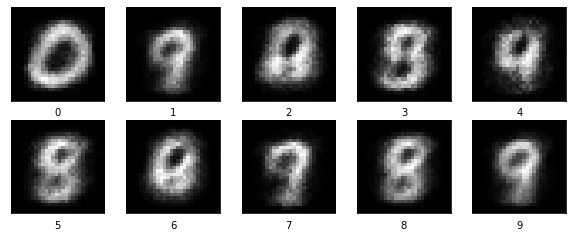

E: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 132.79it/s]


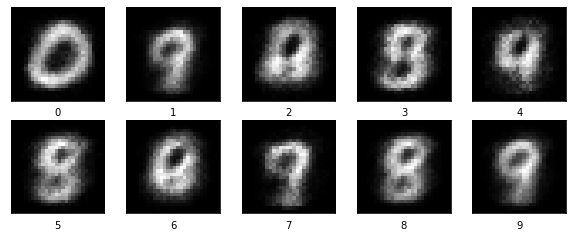

E: 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 111.22it/s]


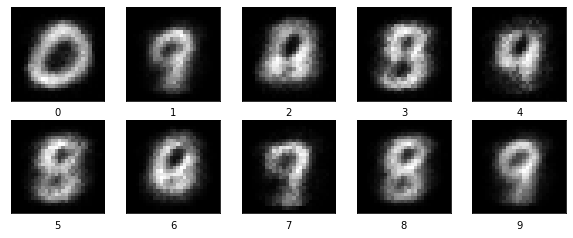

E: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 119.55it/s]


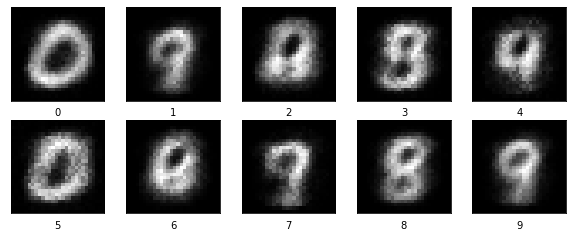

E: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 122.09it/s]


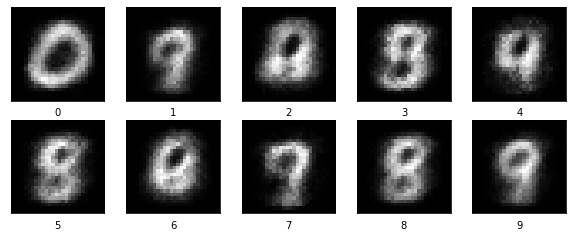

E: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 122.20it/s]


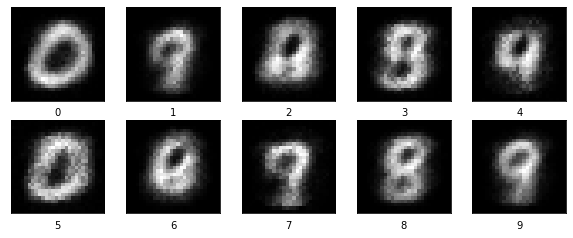

E: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 133.30it/s]


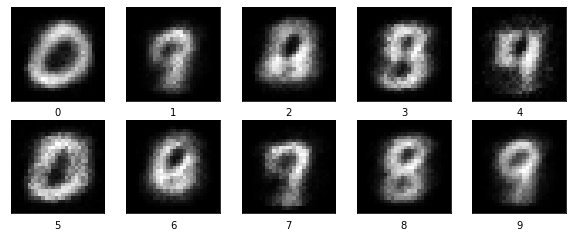

E: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 113.38it/s]


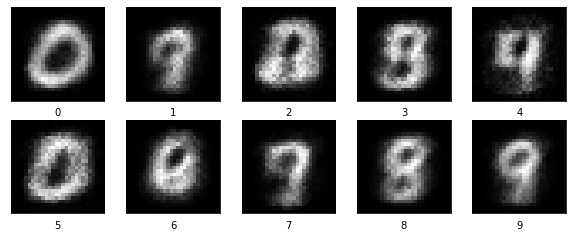

E: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 122.15it/s]


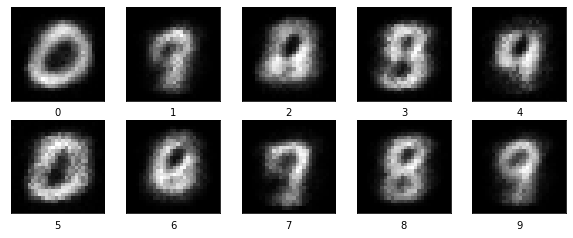

E: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 102.30it/s]


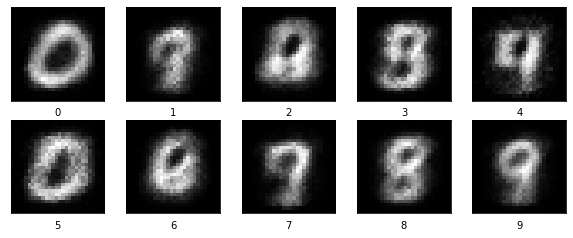

E: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 117.15it/s]


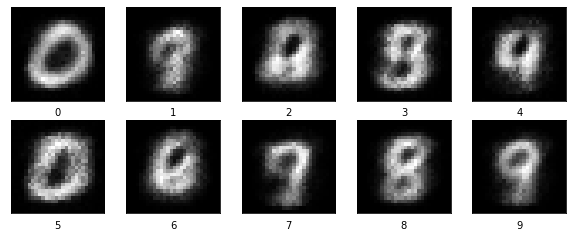

E: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00, 85.03it/s]


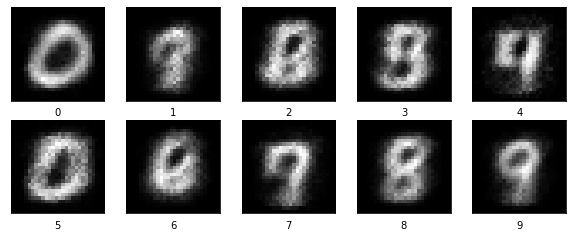

E: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 128.38it/s]


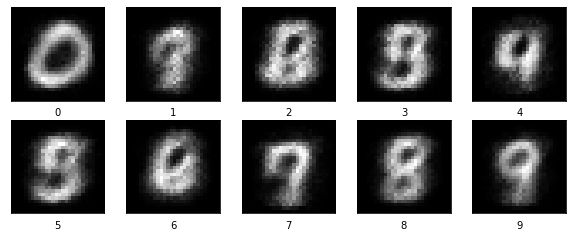

E: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 135.51it/s]


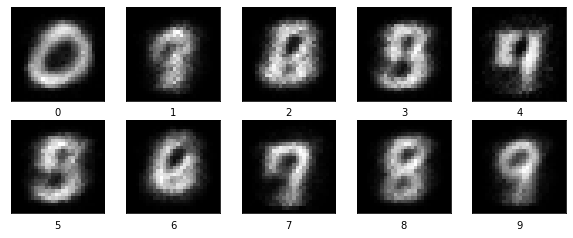

E: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 138.61it/s]


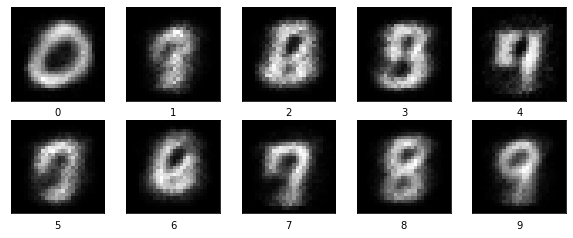

E: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 125.53it/s]


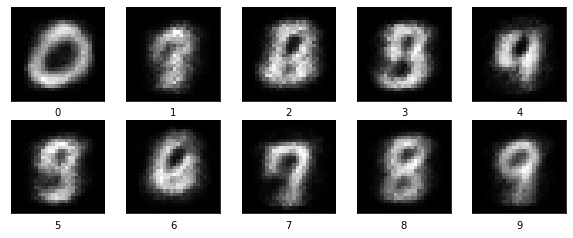

E: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 138.02it/s]


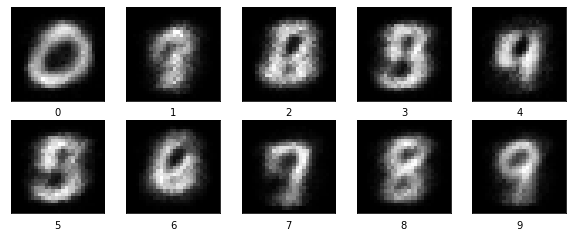

E: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 136.13it/s]


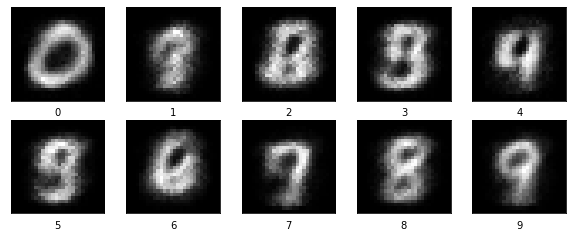

E: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 137.47it/s]


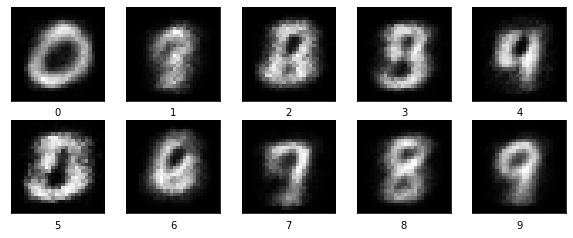

E: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:02<00:00, 142.41it/s]


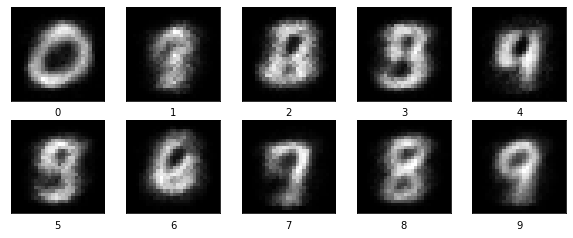

E: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 139.73it/s]


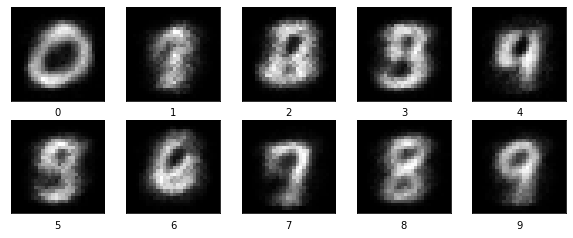

E: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 139.93it/s]


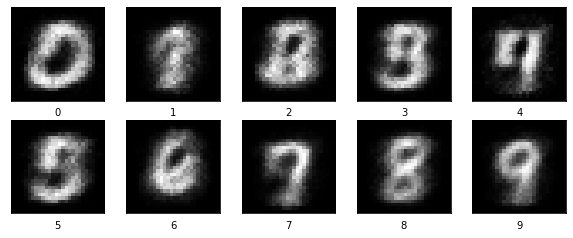

E: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:02<00:00, 140.66it/s]


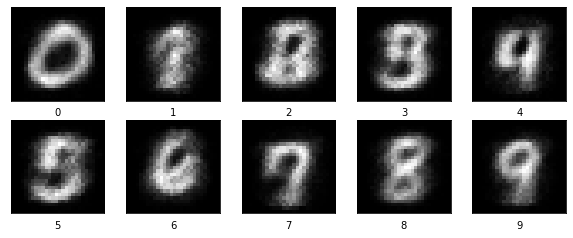

E: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 139.58it/s]


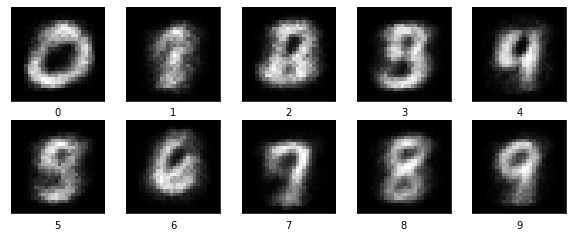

E: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 138.30it/s]


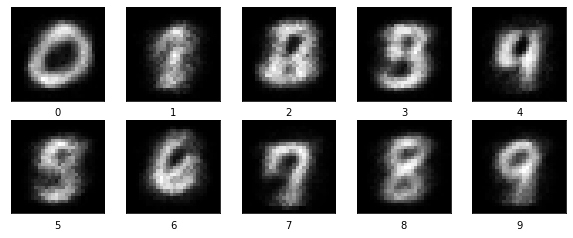

E: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:02<00:00, 141.71it/s]


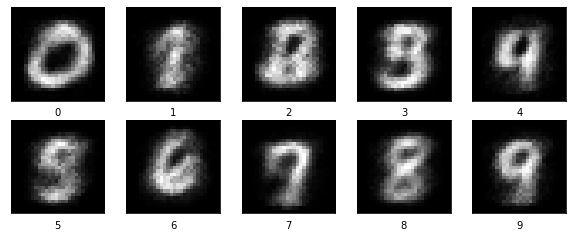

E: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:02<00:00, 142.11it/s]


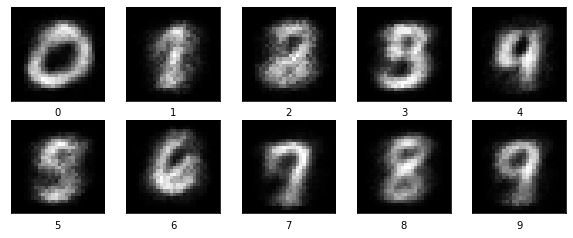

E: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 131.44it/s]


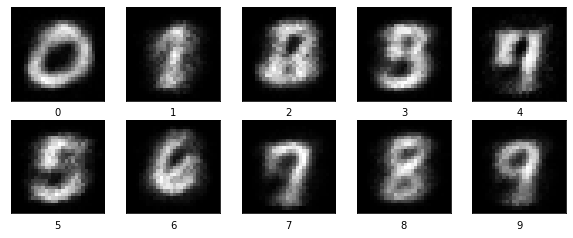

E: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 136.63it/s]


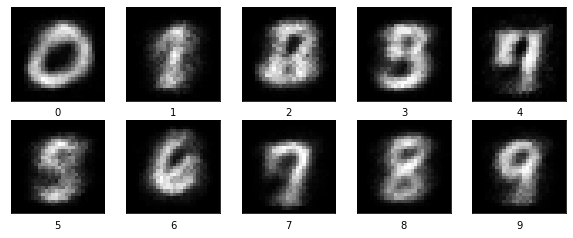

E: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 138.30it/s]


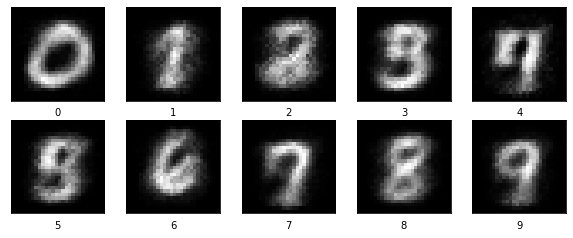

E: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 137.04it/s]


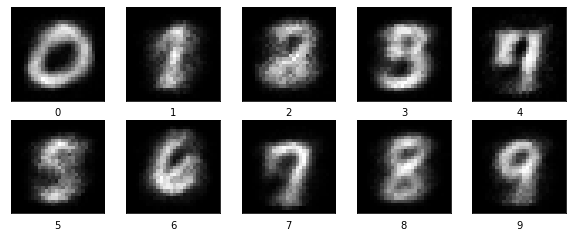

E: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 138.90it/s]


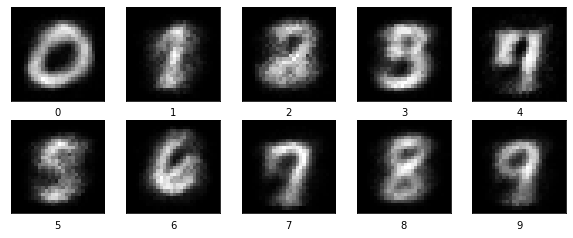

E: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 139.33it/s]


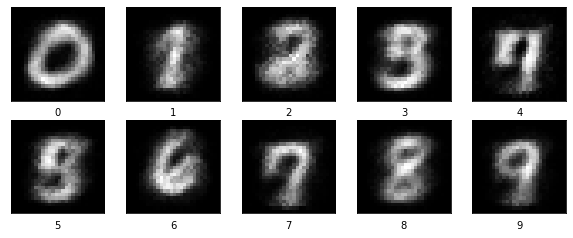

E: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 139.04it/s]


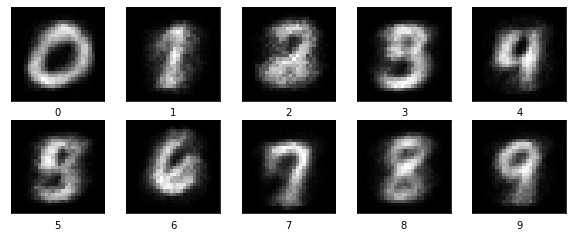

E: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:02<00:00, 141.33it/s]


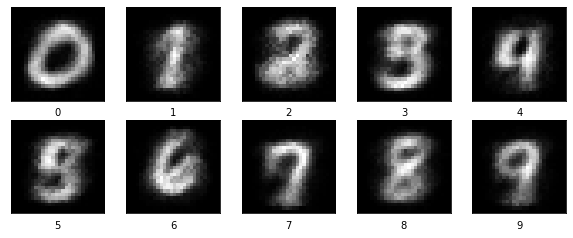

In [601]:
epohs = 70
uprate = 5
print_flag = 5000
_data = test
for e in range(epohs):
    print('E:', e)
    for i in tqdm(range(len(_data))):
        NN.predict( _data.values[i][:1] )
        expect = _data.values[i][1:]
        NN.learn(expect)
        if not i % uprate:
            NN.update(0.01)
        #if not i % print_flag:
        #    print_predictions(NN)
    print_predictions(NN)

/tmp/ipykernel_5437/2918186806.py:33: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1+np.exp(-x)) for x in layer])


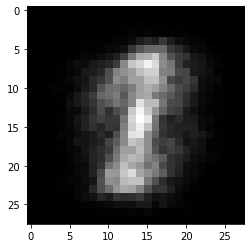

In [602]:
res = NN.predict([1])
plt.imshow(res.reshape(28, 28), cmap='gray')

---------------------------------------------------------------------------

In [603]:
latest = tf.train.latest_checkpoint('models/')
latest

'models/97acc_model'

In [604]:
_filters = 16

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=_filters, kernel_size=(3, 3), activation='softplus', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((4, 4)))

model.add(tf.keras.layers.Conv2D(filters=_filters, kernel_size=(3, 3), activation='softplus'))
model.add(tf.keras.layers.Conv2D(filters=_filters, kernel_size=(3, 3), activation='softplus'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(filters=_filters, kernel_size=(1, 1), activation='softplus'))
model.add(tf.keras.layers.Conv2D(filters=_filters, kernel_size=(1, 1), activation='softplus'))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softplus'))

model.load_weights(latest)


In [605]:
p = tf.stack([res.reshape(28,28)])

In [606]:
np.argmax(model.predict(p[:]))

1/1 [==============================] - 0s 60ms/step


1

In [607]:
def print_gan_predictions(NN, model):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        res = NN.predict([i])
        plt.imshow(res.reshape(28, 28), cmap='gray')

        pp = tf.stack([res.reshape(28,28)])
        pred = np.argmax(model.predict(pp[:], verbose = 0))

        plt.xlabel(" {} ~~ {}".format(i, pred))

    plt.show()

/tmp/ipykernel_5437/2918186806.py:33: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1+np.exp(-x)) for x in layer])


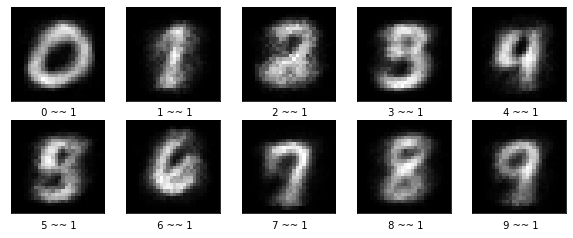

In [608]:
print_gan_predictions(NN, model)


1/1 [==============================] - 0s 19ms/step


/tmp/ipykernel_5437/2918186806.py:33: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1+np.exp(-x)) for x in layer])


array([[0.1259852 , 0.44118655, 0.22884983, 0.34610704, 0.25565264,
        0.31172863, 0.21625514, 0.18376556, 0.27583906, 0.21770896]],
      dtype=float32)

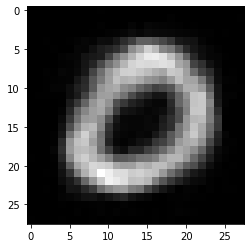

In [609]:
res = NN.predict([0])
plt.imshow(res.reshape(28, 28), cmap='gray')
p = tf.stack([res.reshape(28,28)])
model.predict(p[:])

E: 0


  0%|                                                                                                                | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_5437/2918186806.py:33: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1+np.exp(-x)) for x in layer])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


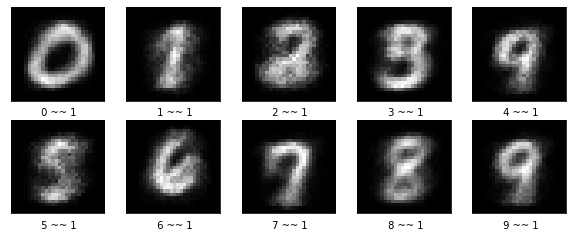

E: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


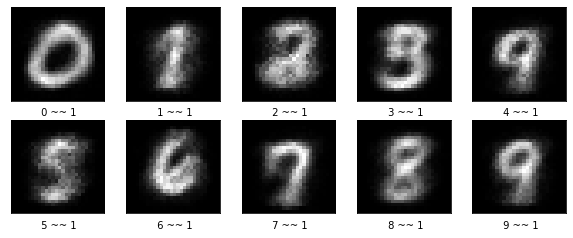

E: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


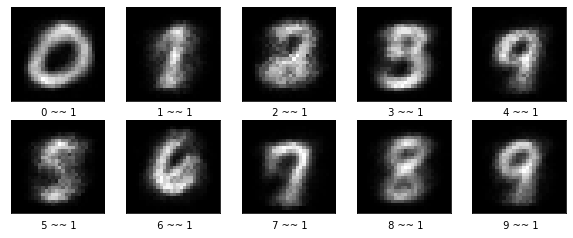

E: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


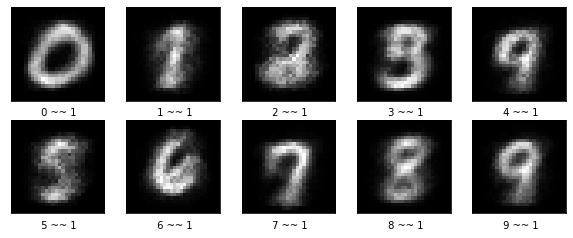

E: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


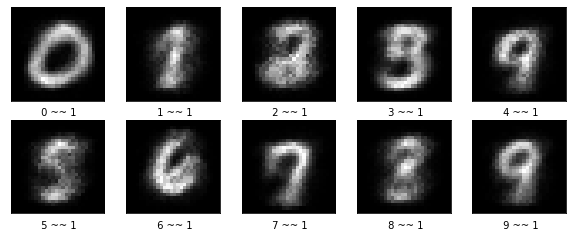

E: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


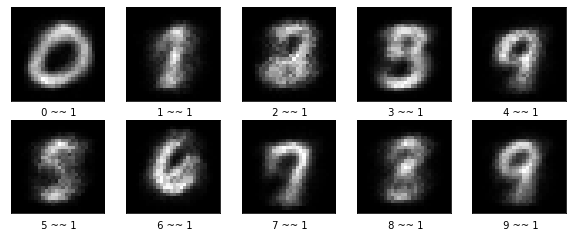

E: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


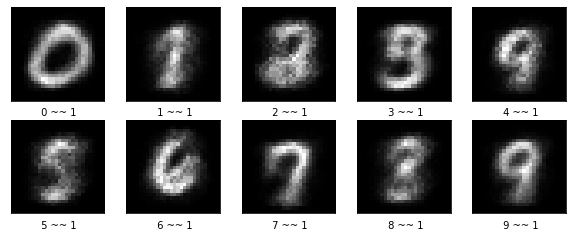

E: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


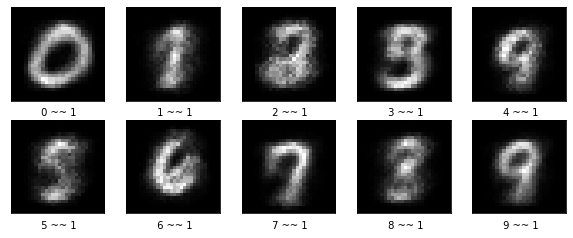

E: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.71it/s]


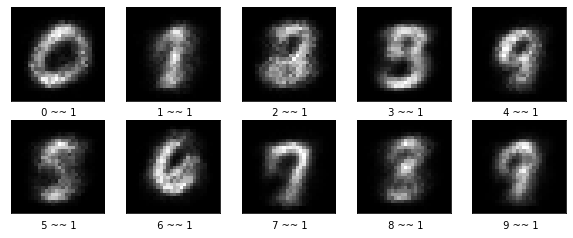

E: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


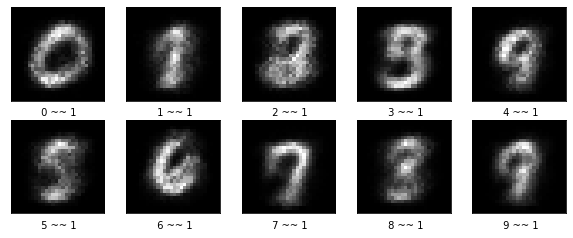

E: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]


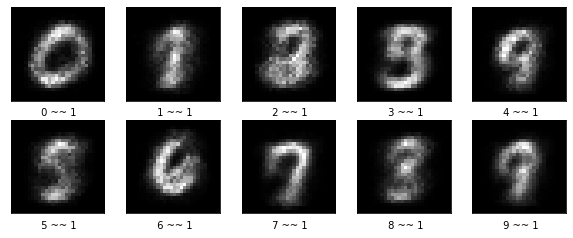

E: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


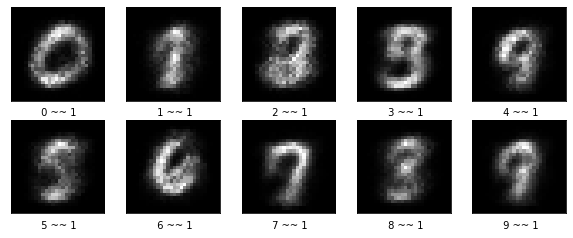

E: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


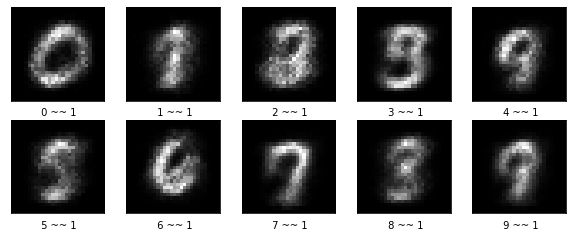

E: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


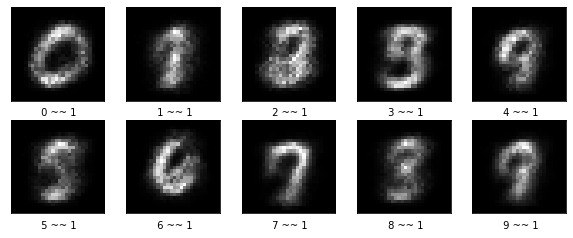

E: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.62it/s]


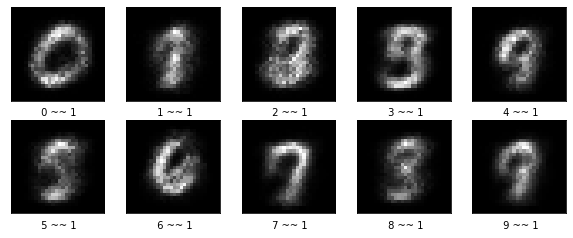

E: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


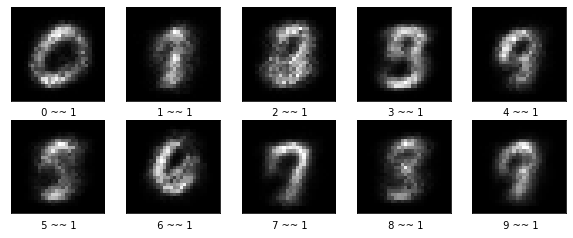

E: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


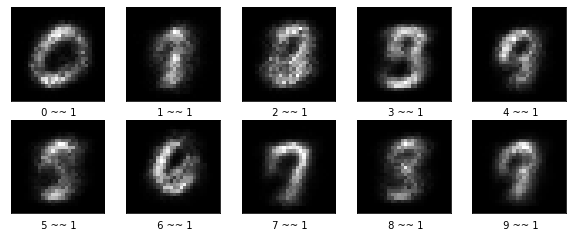

E: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


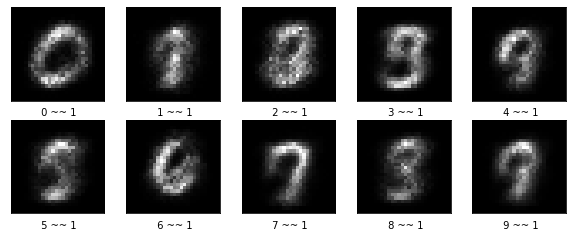

E: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


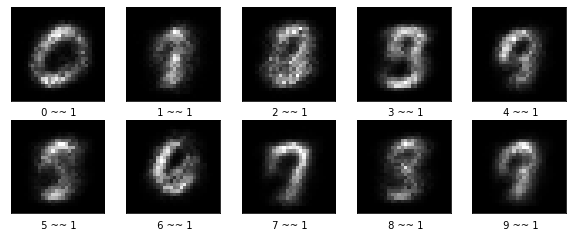

E: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  2.00it/s]


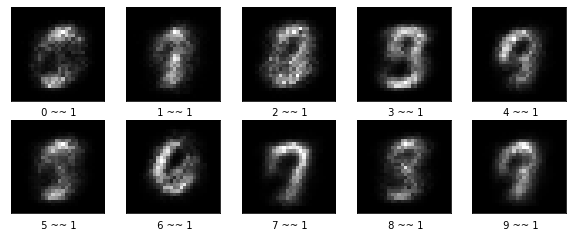

E: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


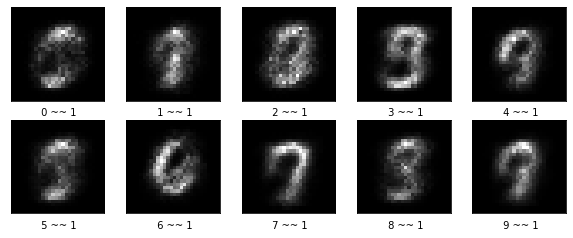

E: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


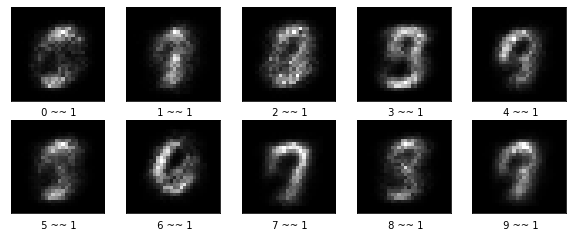

E: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]


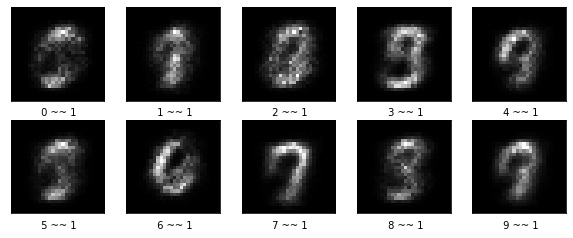

E: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.57it/s]


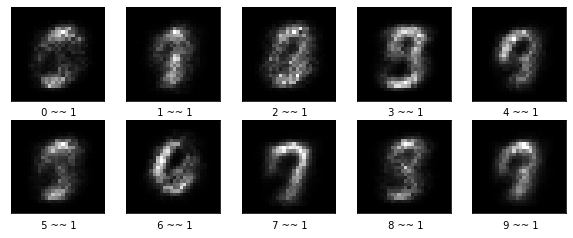

E: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


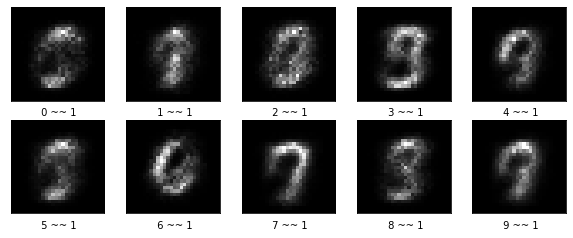

E: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]


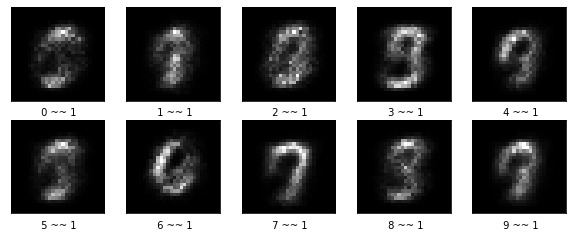

E: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


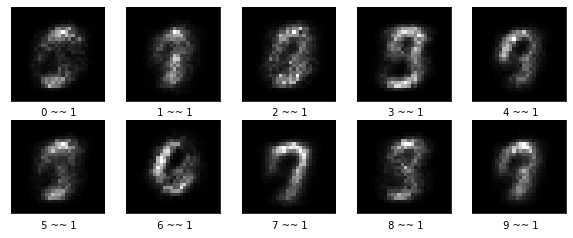

E: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.68it/s]


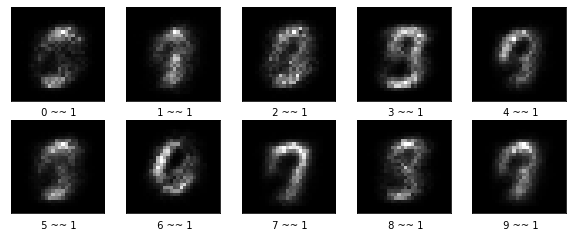

E: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


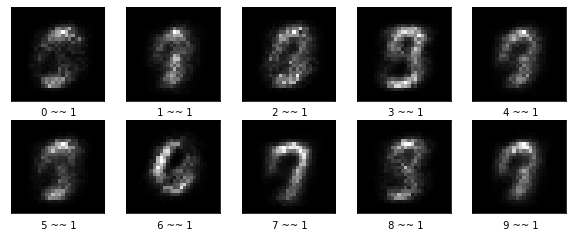

E: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


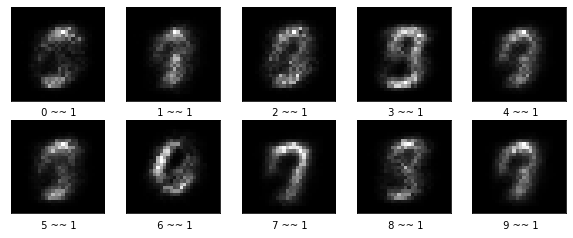

E: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


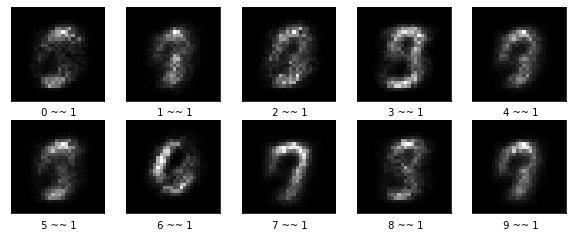

E: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


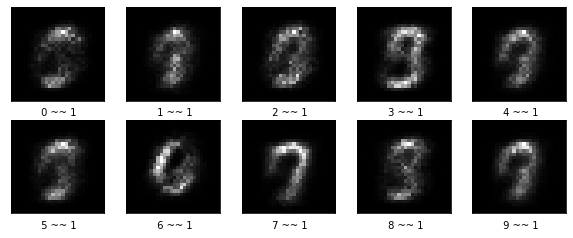

E: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


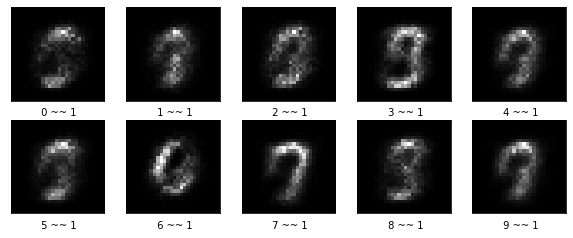

E: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


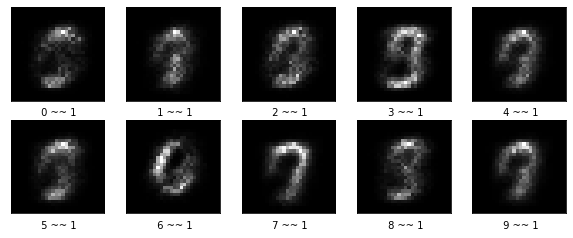

E: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.54it/s]


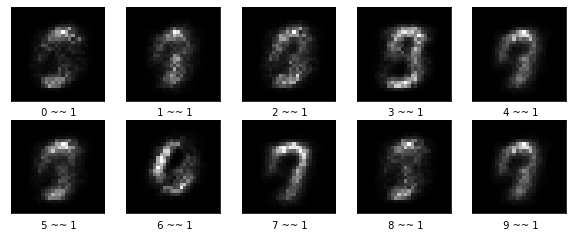

E: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


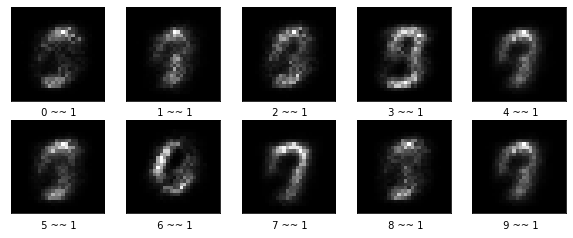

E: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


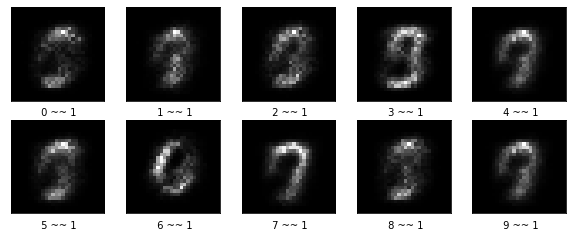

E: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


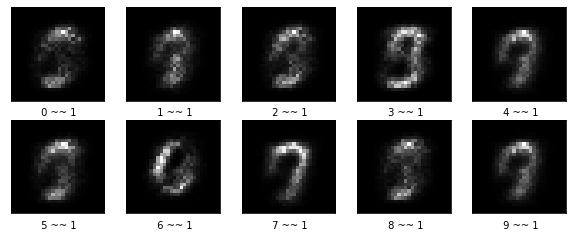

E: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


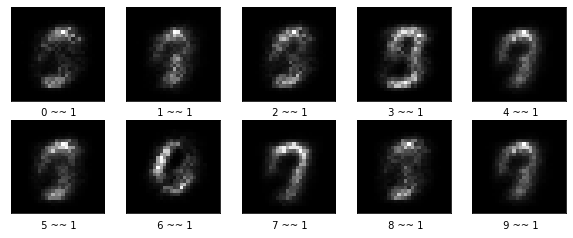

E: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.62it/s]


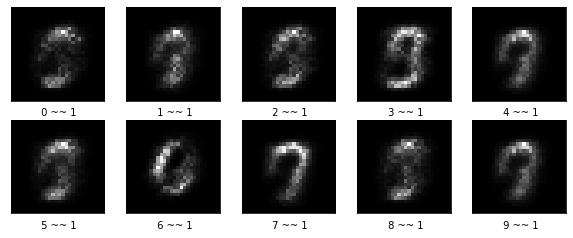

E: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.68it/s]


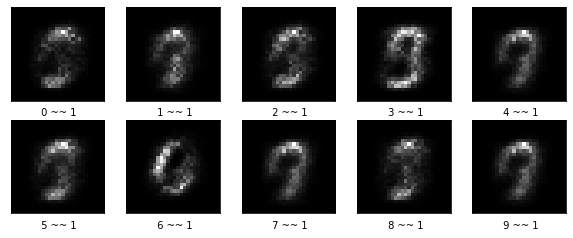

E: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


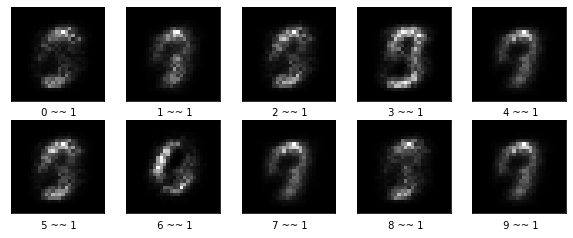

E: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.56it/s]


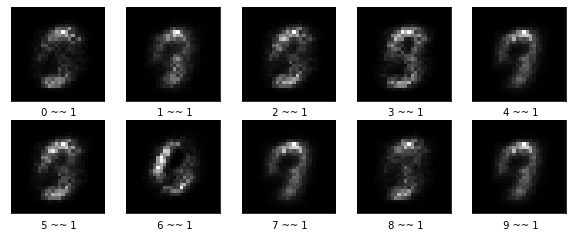

E: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


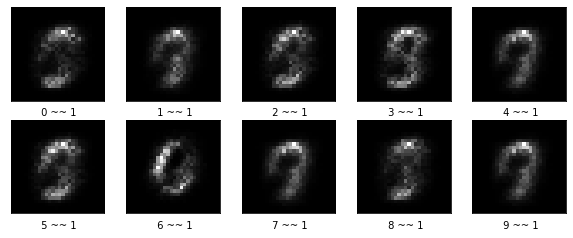

E: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


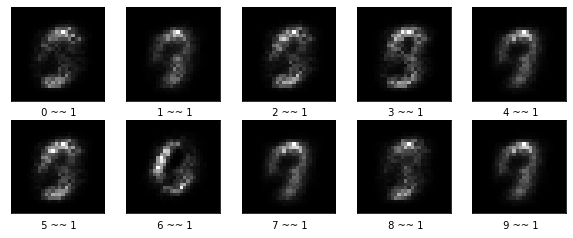

E: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.51it/s]


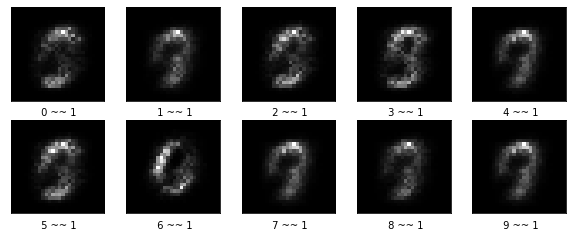

E: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


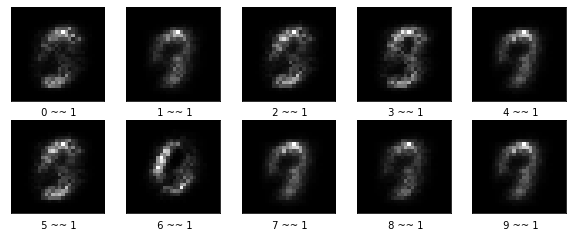

E: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.52it/s]


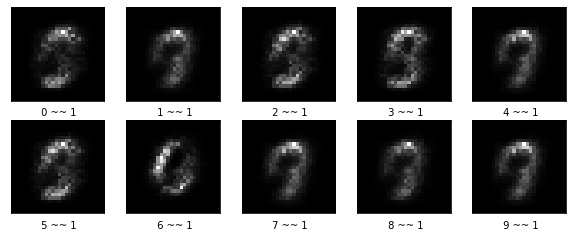

E: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


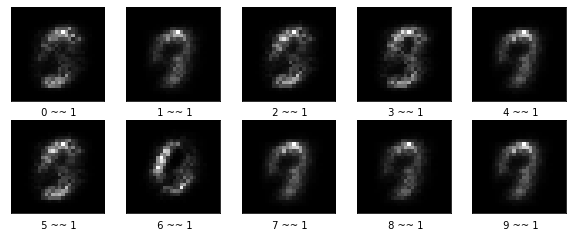

E: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


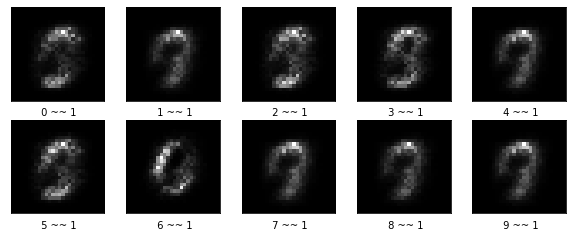

In [610]:
epohs = 50
_data = test
for e in range(epohs):
    print('E:', e)
    for i in tqdm(range(10)):
        for j in range(10):
            res = NN.predict( [j] )
            #plt.imshow(res.reshape(28, 28), cmap='gray')
            p = tf.stack([res.reshape(28,28)])
            expect = model.predict(p[:], verbose = 0)
            NN.gan_learn(1.0 - expect[0][j])
        NN.update(0.0001)
    print_gan_predictions(NN, model)